## Szkieletyzacja (skeletonization)

Szkieletyzacja polega na stopniowym usuwaniu pikseli z krawędzi obiektu, aż pozostanie jego szkielet — cienka linia biegnąca wzdłuż „środka” obiektu.
Szkielet zachowuje:
* kształt (ogólny zarys),
* topologię (połączenia między częściami),
* długość i układ rozgałęzień.

Piksele z brzegu obiektu są usuwane iteracyjnie, ale tylko wtedy, gdy:
* nie naruszają spójności obiektu,
* nie rozdzielają go na kilka części.

## Pocienianie (thinning)

Pocienianie to proces redukcji szerokości obiektu binarnego do linii o grubości jednego piksela, bez koniecznego zachowania osi symetrii jak w szkieletyzacji.
Działa poprzez stopniowe „ścienianie” kształtu z krawędzi, aż obiekt stanie się maksymalnie cienki.

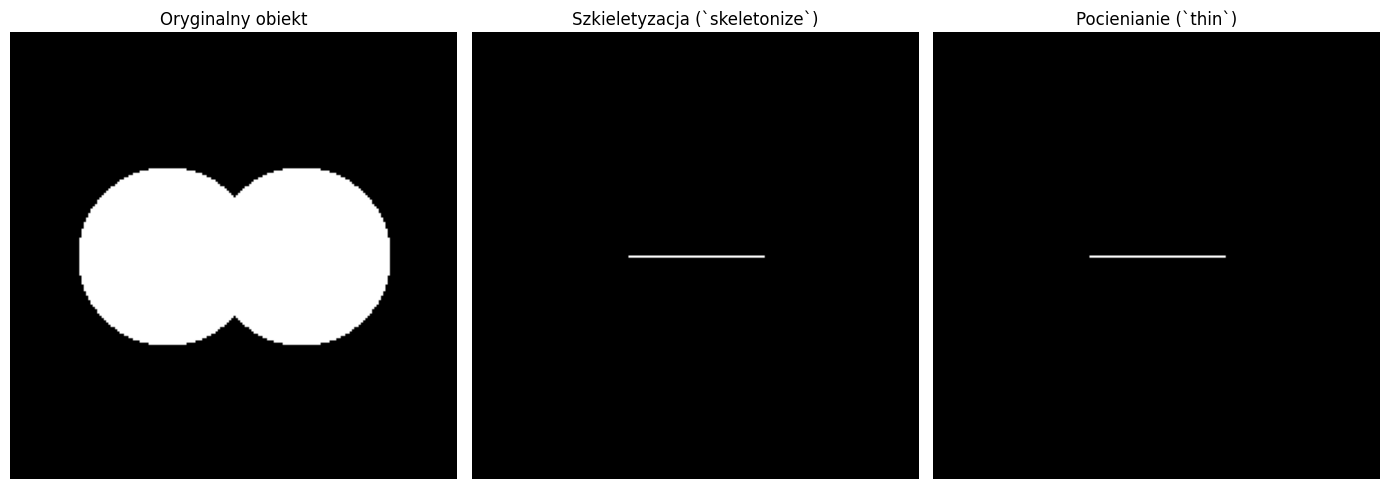

In [67]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import skeletonize, thin
from skimage.draw import disk
from skimage.util import invert
from skimage import io
import skimage.exposure as exp

# Utwórz prosty obiekt (np. dwa połączone okręgi)
image = np.zeros((200, 200), dtype=bool)
rr, cc = disk((100, 70), 40)
image[rr, cc] = 1
rr, cc = disk((100, 130), 40)
image[rr, cc] = 1

# Szkieletyzacja i pocienianie
skeleton = skeletonize(image)
thinned = thin(image)

# Wizualizacja
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Oryginalny obiekt")

ax[1].imshow(skeleton, cmap='gray')
ax[1].set_title("Szkieletyzacja (`skeletonize`)")

ax[2].imshow(thinned, cmap='gray')
ax[2].set_title("Pocienianie (`thin`)")

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

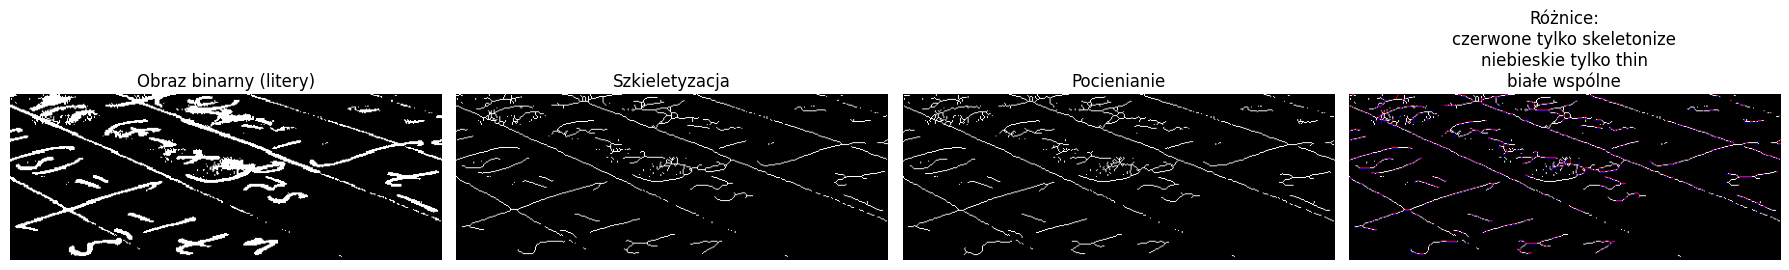

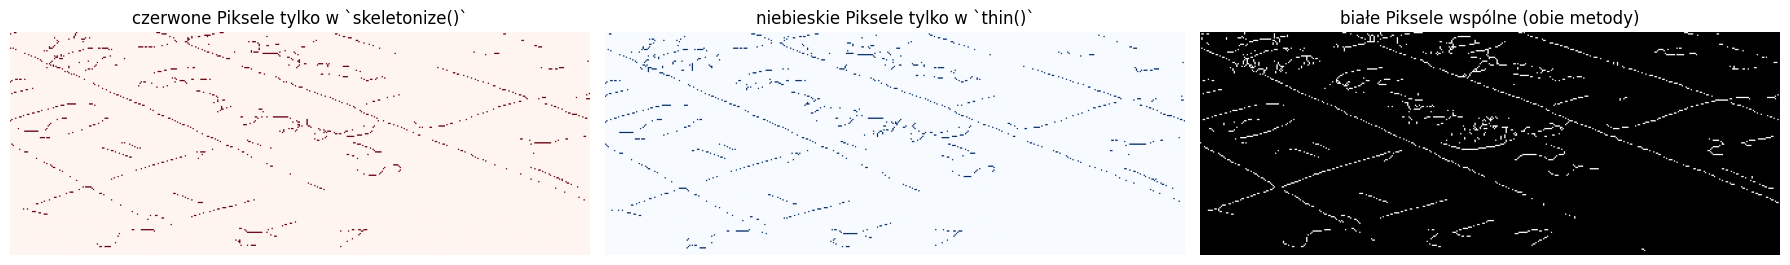

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color
from skimage.filters import threshold_otsu
from skimage.morphology import skeletonize, thin

# Wczytaj obraz tekstu
img = data.text()

# Sprawdź czy RGB czy już 2D
if img.ndim == 3:
    gray = color.rgb2gray(img)
else:
    gray = img.astype(np.float64)
    if gray.max() > 1.0:
        gray /= gray.max()

# Binarizacja
th = threshold_otsu(gray)
binary = gray < th
binary = binary.astype(bool)

# Szkieletyzacja i pocienianie
skel = skeletonize(binary)
thin_img = thin(binary)

# Oblicz różnice
only_skel = np.logical_and(skel, np.logical_not(thin_img))   # czerwone
only_thin = np.logical_and(thin_img, np.logical_not(skel))   # niebieskie
both = np.logical_and(skel, thin_img)                        # wspólne (białe)

# Utwórz kolorowy obraz różnic
diff_rgb = np.zeros((*binary.shape, 3))
diff_rgb[..., 0] = only_skel      # red channel
diff_rgb[..., 2] = only_thin      # blue channel
diff_rgb[..., 0:3] += both[..., None]  # dodaj wspólne (biały)

# --- Główne porównanie (4 obrazy) ---
fig, ax = plt.subplots(1, 4, figsize=(18, 5))
ax[0].imshow(binary, cmap='gray')
ax[0].set_title("Obraz binarny (litery)")

ax[1].imshow(skel, cmap='gray')
ax[1].set_title("Szkieletyzacja")

ax[2].imshow(thin_img, cmap='gray')
ax[2].set_title("Pocienianie")

ax[3].imshow(diff_rgb)
ax[3].set_title("Różnice:\nczerwone tylko skeletonize\nniebieskie tylko thin\nbiałe wspólne")

for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()

# --- Dodatkowe trzy obrazy osobno ---
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].imshow(only_skel, cmap='Reds')
ax[0].set_title("czerwone Piksele tylko w `skeletonize()`")

ax[1].imshow(only_thin, cmap='Blues')
ax[1].set_title("niebieskie Piksele tylko w `thin()`")

ax[2].imshow(both, cmap='gray')
ax[2].set_title("białe Piksele wspólne (obie metody)")

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

* Czerwony - Piksele obecne tylko w skeletonize - Ta metoda zostawia nieco „grubsze” fragmenty i rozgałęzienia.
* Niebieski	- Piksele obecne tylko w thin	Pocienianie usuwa więcej pikseli – daje cieńszy, jednolity szkielet.
* Biały	- Piksele wspólne	To „rdzeń” kształtu – wspólna oś uznana przez obie metody.

## Przycinanie (z ang. Pruning) to proces usuwania krótkich, nieistotnych gałązek ze szkieletu obiektu binarnego.
Celem tej operacji jest oczyszczenie szkieletu z drobnych odgałęzień, które powstały w wyniku:

* szumów w obrazie,
* niejednorodnego oświetlenia,
* nieidealnej segmentacji lub binarizacji.

Metody przycinania

* Iteracyjne usuwanie końcówek - najprostsza metoda: w każdej iteracji usuwa się piksele końcowe (z jednym sąsiadem). Po kilku iteracjach znikają krótkie odnogi, ale główny kształt zostaje zachowany.

* Pruning oparty na długości gałęzi. Wykrywa wszystkie gałęzie i mierzy ich długość (np. przez przeszukiwanie grafu). Usuwa tylko te, których długość < ustalonego progu (np. 10 pikseli).

* Pruning morfologiczny - Wykorzystuje operacje morfologiczne (np. hit-or-miss) do usuwania specyficznych wzorców końcówek.

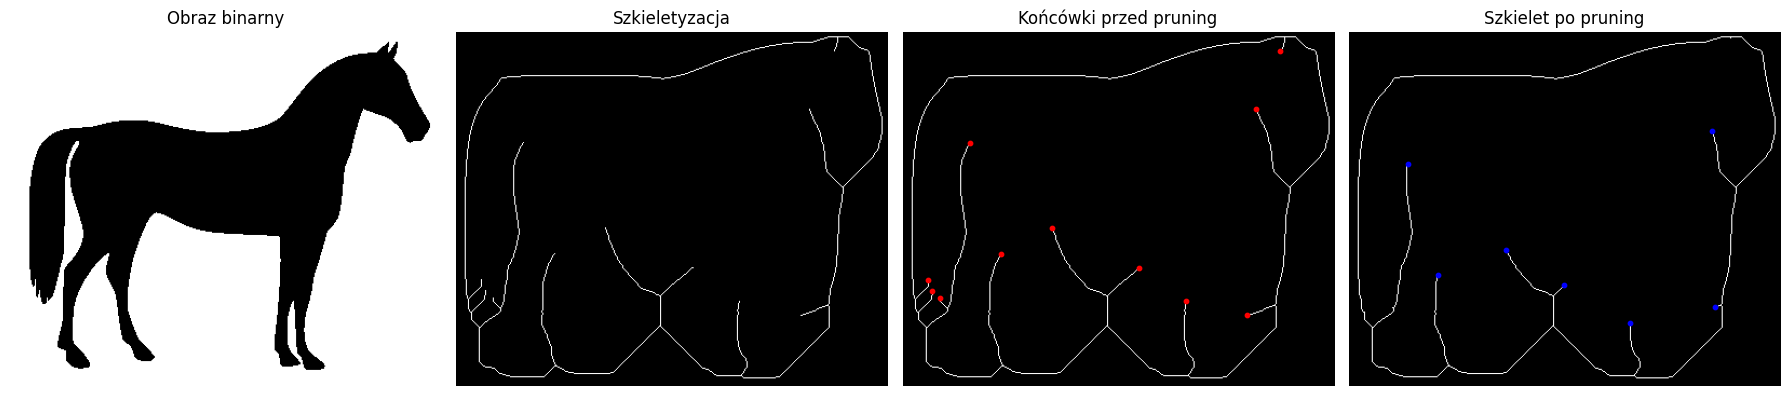

Piksele szkieletu (przed): 1823
Piksele szkieletu (po)   : 1624
Końcówki (przed)         : 11
Końcówki (po)            : 7


In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve
from skimage import data, color
from skimage.filters import threshold_otsu
from skimage.morphology import skeletonize, remove_small_objects, binary_closing, binary_opening

# --------- 0) Pomocnicze: bezpieczne przygotowanie obrazu binarnego ---------
def to_binary(img):
    """Zwraca obraz binarny (bool) niezależnie od formatu wejścia."""
    if img.dtype == bool and img.ndim == 2:
        return img
    if img.ndim == 3:   # RGB -> gray
        gray = color.rgb2gray(img)
    else:               # już 2D
        gray = img.astype(float)
        if gray.max() > 1.0:  # unormuj jeśli trzeba
            gray /= gray.max()
    th = threshold_otsu(gray)
    return (gray < th)  # ciemne obiekty = True

# Dane i binarizacja
img = data.horse()              # 2D (często bool)
binary = to_binary(img)
binary = remove_small_objects(binary, 64)

# Szkieletyzacja
skel = skeletonize(binary)

# Końcówki i pruning
def find_endpoints(skel_bool):
    """Zwraca maskę końcówek (pikseli z 1 sąsiadem w 8-sąsiedztwie)."""
    # 10 dla centrum, 1 dla sąsiadów -> 10 + 1 = 11 oznacza końcówkę
    kernel = np.array([[1,1,1],
                       [1,10,1],
                       [1,1,1]])
    conv = convolve(skel_bool.astype(np.uint8), kernel, mode='constant', cval=0)
    return conv == 11

def find_junctions(skel):
    """Zwraca maskę prawdziwych przecięć na podstawie crossing number."""
    sk = skel.astype(np.uint8)

    # 8 sąsiadów zgodnie z kierunkami kolejności
    kernel_list = [
        np.array([[0,0,0],
                  [0,0,1],
                  [0,0,0]]),
        
        np.array([[0,0,0],
                  [0,0,0],
                  [0,0,1]]),
        
        np.array([[0,0,0],
                  [1,0,0],
                  [0,0,0]]),
        
        np.array([[1,0,0],
                  [0,0,0],
                  [0,0,0]]),
    ]

    # kierunki 8-sąsiedztwa
    neighbors = []
    for ky in [-1,0,1]:
        for kx in [-1,0,1]:
            if not (kx==0 and ky==0):
                neighbors.append(np.roll(np.roll(sk, ky, axis=0), kx, axis=1))

    P = neighbors
    # CN formula
    CN = (np.abs(P[0]-P[1]) + np.abs(P[1]-P[2]) + np.abs(P[2]-P[3]) +
          np.abs(P[3]-P[4]) + np.abs(P[4]-P[5]) + np.abs(P[5]-P[6]) +
          np.abs(P[6]-P[7]) + np.abs(P[7]-P[0])) / 2

    return (CN >= 3) & sk

def prune_skeleton(skel_bool, max_len=15):
    """
    Iteracyjnie usuwa końcówki do zadanej długości gałązki (max_len w pikselach).
    Każda iteracja odcina 1 piksel na końcu gałęzi.
    """
    pruned = skel_bool.copy()
    for _ in range(max_len):
        endpoints = find_endpoints(pruned)
        # zatrzymaj, gdy nie ma już krótkich końcówek
        if not endpoints.any():
            break
        pruned = np.logical_and(pruned, ~endpoints)
    return pruned

pruned = prune_skeleton(skel, max_len=20)

# Wizualizacja: oryginał, szkielet, końcówki, pruning
endpoints_before = find_endpoints(skel)
endpoints_after  = find_endpoints(pruned)

fig, ax = plt.subplots(1, 4, figsize=(18, 5))
ax[0].imshow(binary, cmap='gray'); ax[0].set_title("Obraz binarny"); ax[0].axis('off')
ax[1].imshow(skel, cmap='gray');   ax[1].set_title("Szkieletyzacja"); ax[1].axis('off')

# nałóż końcówki przed pruning (czerwone)
ax[2].imshow(skel, cmap='gray')
y, x = np.where(endpoints_before)
ax[2].scatter(x, y, s=10, c='r')
ax[2].set_title("Końcówki przed pruning"); ax[2].axis('off')

# szkielet po pruning + końcówki po (niebieskie)
ax[3].imshow(pruned, cmap='gray')
y2, x2 = np.where(endpoints_after)
ax[3].scatter(x2, y2, s=10, c='b')
ax[3].set_title("Szkielet po pruning"); ax[3].axis('off')

plt.tight_layout()
plt.show()

# Prosta statystyka
print("Piksele szkieletu (przed):", int(skel.sum()))
print("Piksele szkieletu (po)   :", int(pruned.sum()))
print("Końcówki (przed)         :", int(endpoints_before.sum()))
print("Końcówki (po)            :", int(endpoints_after.sum()))

# Zadanie 1. Analiza układu naczyń krwionośnych (lub dróg) z wykorzystaniem szkieletyzacji

Cel:
Zastosować szkieletyzację do analizy i modelowania rozgałęzionej struktury obiektów — takich jak naczynia krwionośne, korzenie roślin, sieci drogowe lub linie pisma.
Celem jest uzyskanie uproszczonej reprezentacji struktury (szkieletu), która zachowuje topologię, umożliwia pomiar długości i rozgałęzień.

Wyobraź sobie, że jesteś inżynierem biomedycznym analizującym zdjęcia mikroskopowe naczyń krwionośnych. Obraz jest binarny (ciemne naczynia na jasnym tle). Chcesz automatycznie:

* uzyskać szkielet naczyń,
* obliczyć łączną długość naczyń,
* określić liczbę rozgałęzień i końcówek.

Podobne podejście można wykorzystać np. w analizie:

* sieci dróg z obrazów satelitarnych,
* struktur roślinnych (korzeni, liści),
* połączeń ścieżek w układach scalonych.


In [70]:
def show_image(image, title=None):
    plt.imshow(image, "gray")
    plt.title(title)
    plt.axis("off")
    plt.show()

In [71]:
def show_row(images, labels):
    _, axs = plt.subplots(1, len(images), figsize=(10*len(images)*(len(images[0])/len(images[0][0])), 10*(len(images[0][0])/len(images[0]))))

    for i, ax in enumerate(axs):
        ax.imshow(images[i], "gray")
        ax.set_title(labels[i])
        ax.axis("off")
    
    plt.show()

In [72]:
def show_matrix(images, labels):
    _, axes = plt.subplots(len(images), len(images[0]), figsize=(6*len(images), 3*(len(images[0]))))

    for j in range(len(images)):
        for i in range(len(images[0])):
            axes[j, i].imshow(images[j][i], "gray")
            axes[j, i].set_title(labels[j][i])
            axes[j, i].axis("off")
    
    plt.show()

In [73]:
def show_matrix_endpoints(images, labels, endpoints):

    _, axes = plt.subplots(len(images), len(images[0]), figsize=(10*len(images), 8*(len(images[0]))))

    for j in range(len(images)):
        for i in range(len(images[0])):
            axes[j, i].imshow(images[j][i], "gray")
            if j == 1:
                y, x = np.where(endpoints[i])
                axes[j, i].scatter(x, y, s=10, c='pink')
                
            axes[j, i].set_title(labels[j][i])
            axes[j, i].axis("off")
    plt.show()


# Kolejne kroki

Wczytaj obraz (np. mikroskopowy obraz naczyń lub sieć dróg — można użyć data.retina() lub własnego zdjęcia).
Jeśli obraz jest kolorowy — przekształć go do skali szarości.

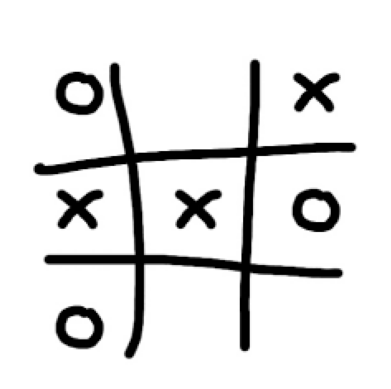

In [74]:
img = io.imread("data/ttt.png")[:, :, 0]
show_image(img)

1. Wykonaj progowanie (np. metodą Otsu), aby uzyskać obraz binarny przedstawiający strukturę obiektu.


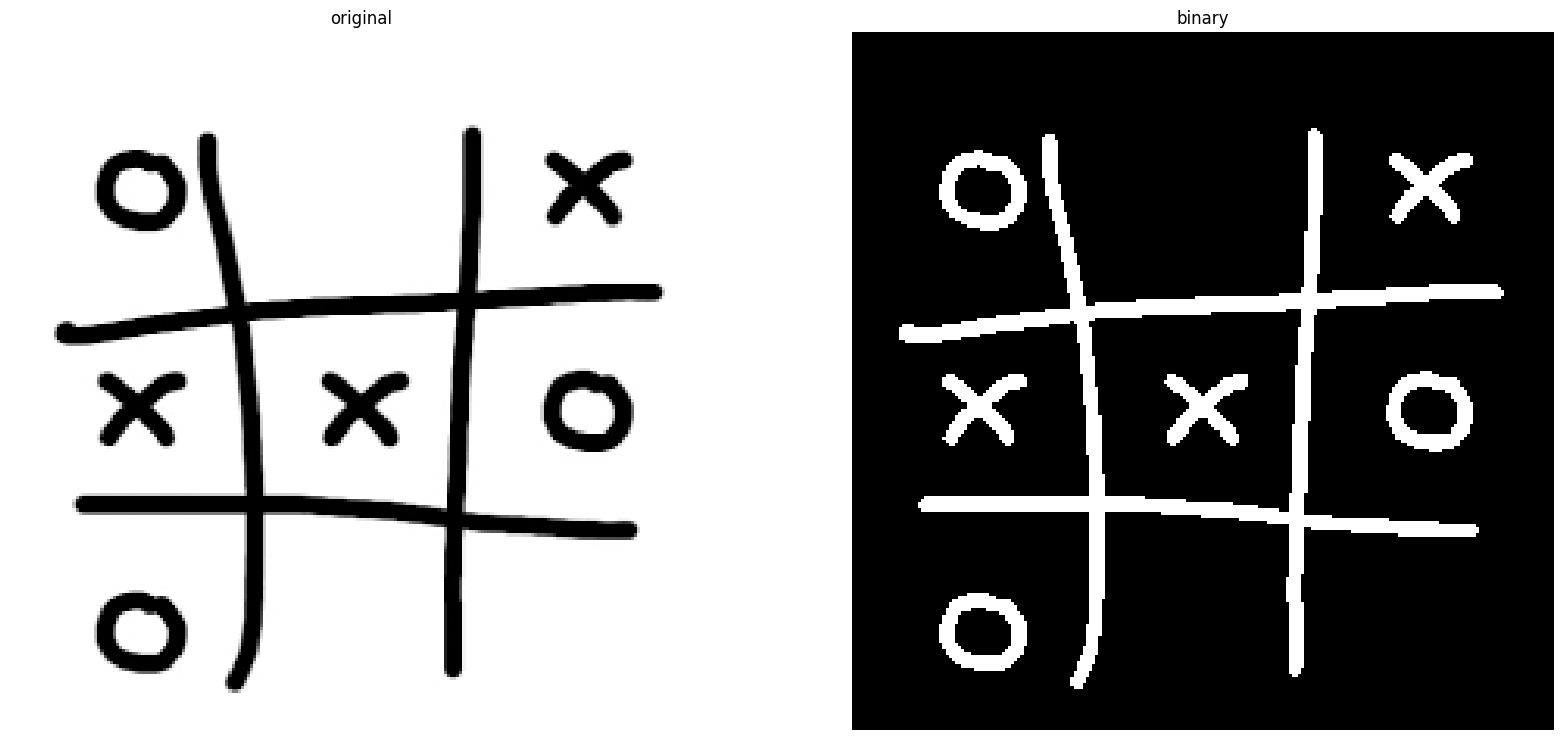

In [75]:
binary_img = to_binary(exp.adjust_gamma(img, 0.25))
show_row([img, binary_img], ["original", "binary"])


2. Wyczyść obraz – usuń małe obiekty i zakłócenia (remove_small_objects, closing, opening).

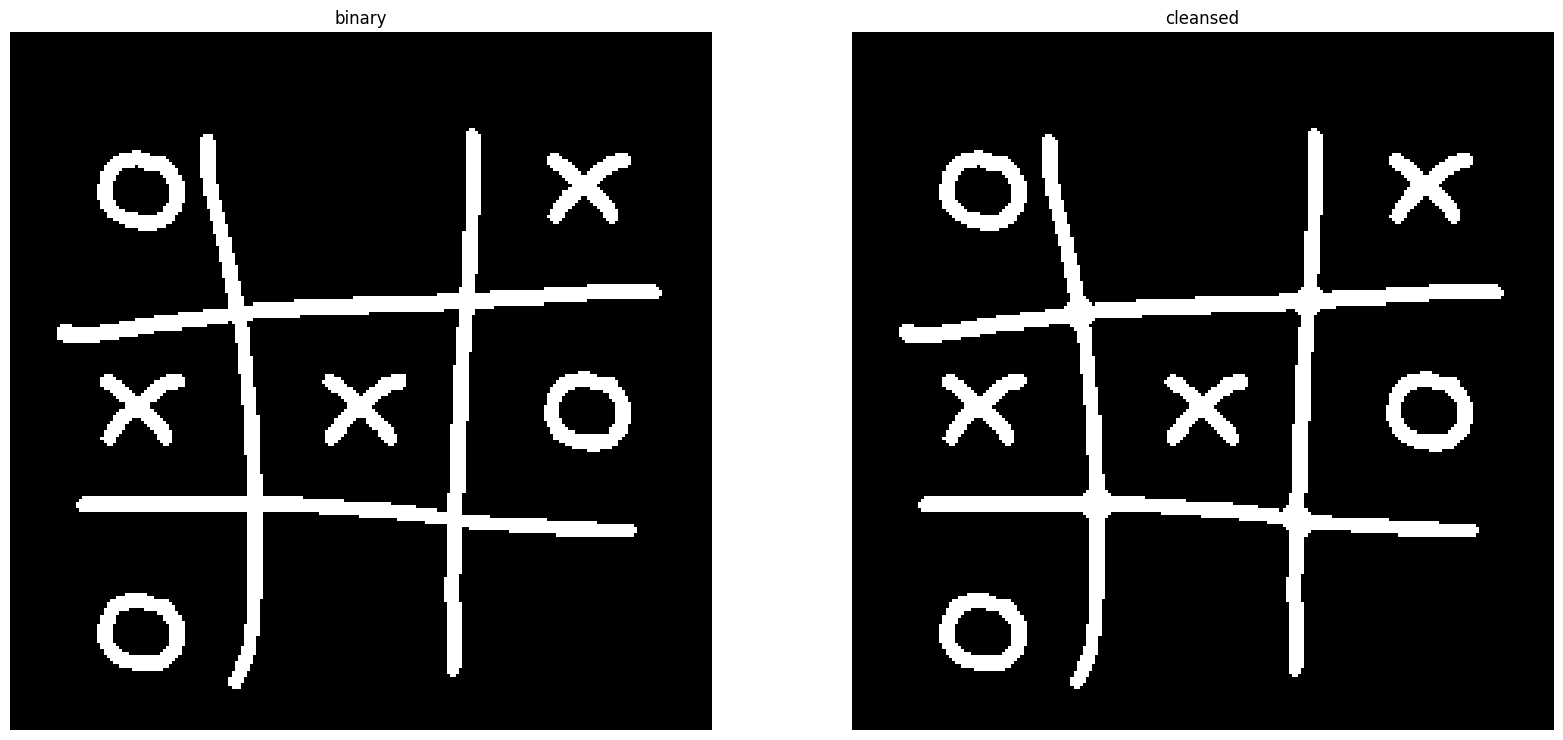

In [76]:
from skimage.morphology import disk

clean_img = binary_closing(binary_img, disk(2))
clean_img = binary_opening(clean_img, disk(1))
clean_img = remove_small_objects(clean_img, 200)

show_row([binary_img, clean_img], ["binary", "cleansed"])

3. Zastosuj szkieletyzację (skeletonize) do uzyskania osi struktur.

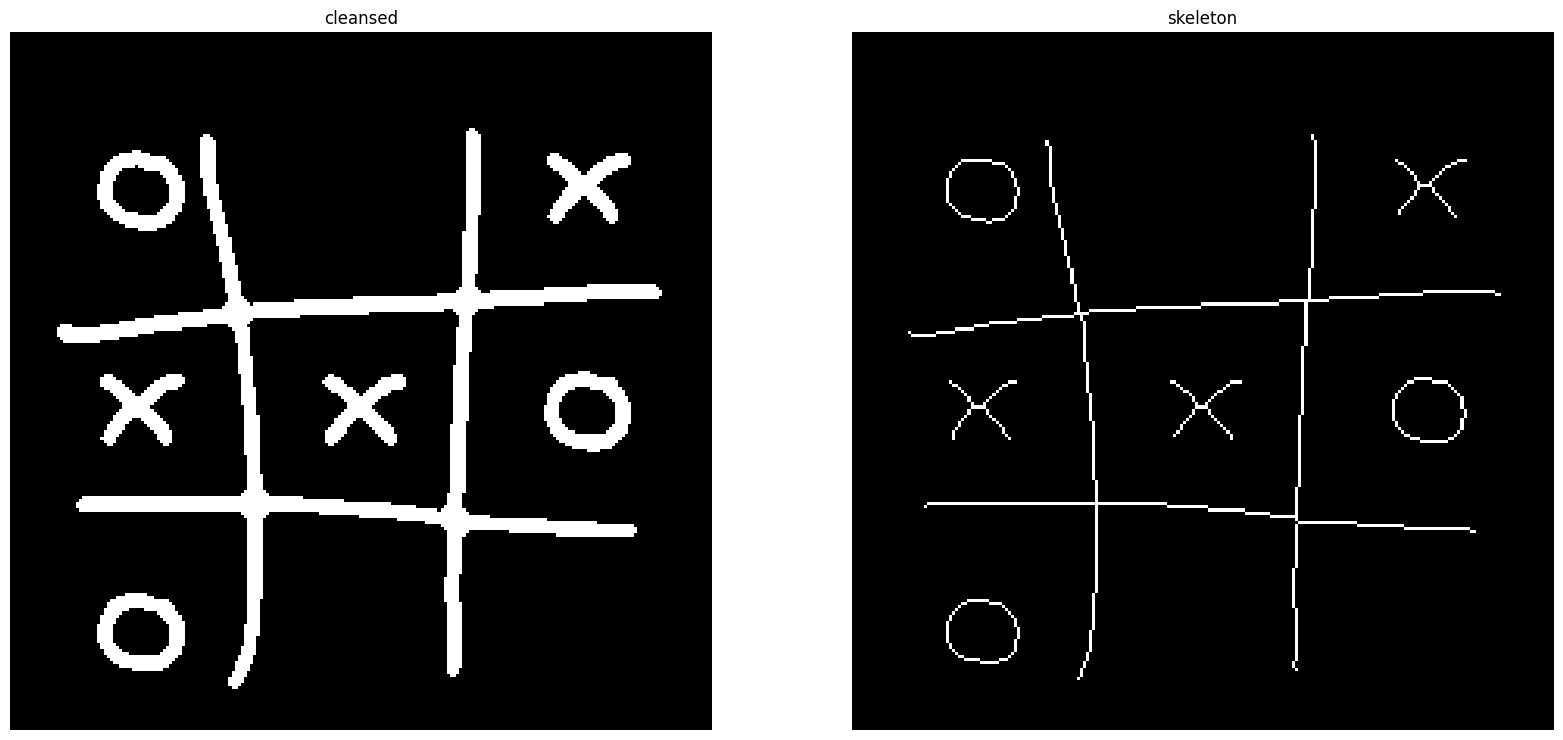

In [77]:
skeleton = skeletonize(clean_img)
show_row([clean_img, skeleton], ["cleansed", "skeleton"])

4. Oblicz cechy geometryczne:

* liczbę końcówek szkieletu (punkty z jednym sąsiadem),
* liczbę rozgałęzień (punkty z więcej niż dwoma sąsiadami).

In [78]:
skeleton_endpoints = find_endpoints(skeleton)
skeleton_crossroads = find_crossroads(skeleton)
pruned = prune_skeleton(skeleton, max_len=100)
pruned_endpoints = find_endpoints(pruned)


Koncepcja cech geometrycznych szkieletu:
Każdy piksel w szkielecie ma pewną liczbę sąsiadów (8-sąsiedztwo):
* Końcówka (endpoint): piksel, który ma dokładnie jednego sąsiada.
→ Jest to koniec gałęzi szkieletu.
* Rozgałęzienie (branch point): piksel, który ma więcej niż dwóch sąsiadów.→ W tym miejscu łączą się lub rozdzielają gałęzie struktury.


Wizualizuj wynik:

* oryginalny obraz,
* obraz binarny,
* szkielet

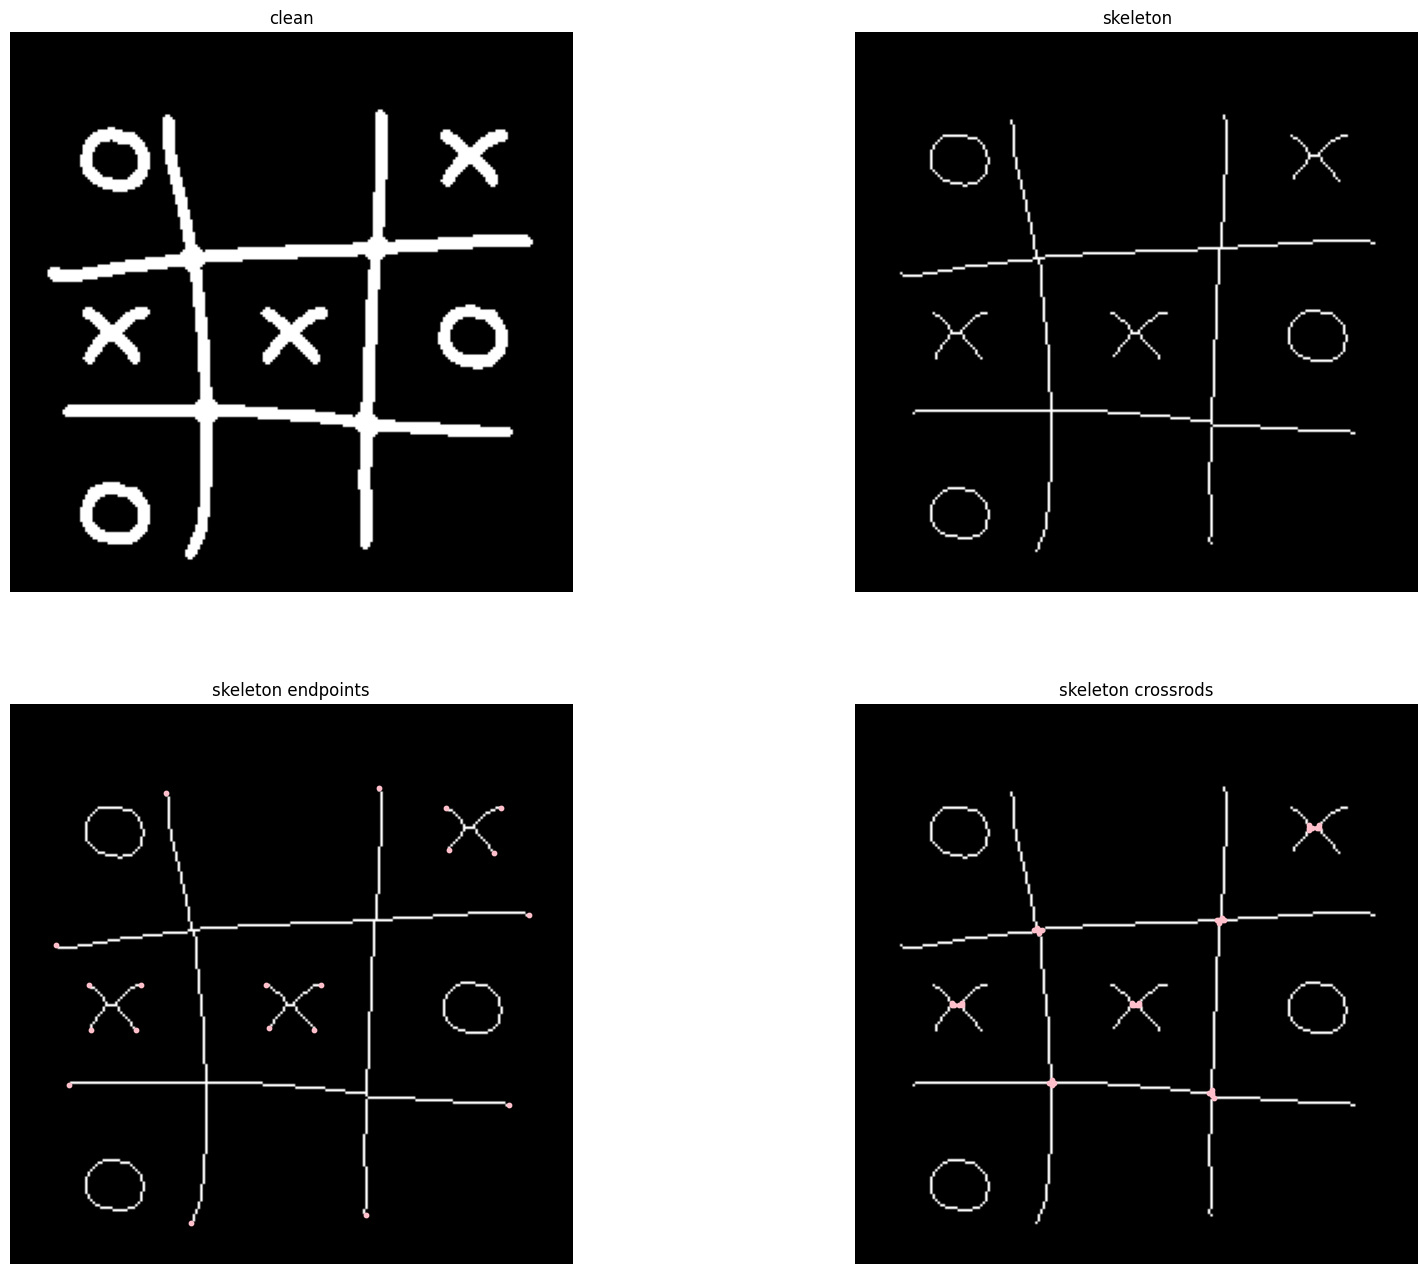

[False  True]
bool (224, 225)
Min neighbors: 2
Max neighbors: 5
Piksele szkieletu (przed): 1028
Piksele szkieletu (po)   : 482
Końcówki (przed)         : 20
Końcówki (po)            : 10


In [79]:
show_matrix_endpoints([[clean_img, skeleton], [skeleton, skeleton]], 
                      [["clean", "skeleton"], ["skeleton endpoints", "skeleton crossrods"]],
                        (skeleton_endpoints, skeleton_crossroads))


print(np.unique(skeleton))
print(skeleton.dtype, skeleton.shape)
print("Min neighbors:", convolve(skeleton.astype(np.uint8), np.ones((3,3)), mode='constant')[skeleton>0].min())
print("Max neighbors:", convolve(skeleton.astype(np.uint8), np.ones((3,3)), mode='constant')[skeleton>0].max())
# Prosta statystyka
print("Piksele szkieletu (przed):", int(skeleton.sum()))
print("Piksele szkieletu (po)   :", int(pruned.sum()))
print("Końcówki (przed)         :", int(skeleton_endpoints.sum()))
print("Końcówki (po)            :", int(skeleton_crossroads.sum()/4))